# Customer Churn Prediction - Data Preparation

This notebook implements the data cleaning and preprocessing pipeline for the customer churn prediction project.

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

# Set up logging
import logging
import sys
# date_strftime_format = "%Y-%m-%y %H:%M:%S"
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(message)s")

# Add the src directory to the path to import custom modules
sys.path.append('../')
from src.data.data_processing import load_data, save_processed_data

# Set up plotting
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

## 1. Load the Data

In [2]:
# Define file paths
RAW_DATA_PATH = '../data/raw/churn.csv'
PROCESSED_DATA_PATH = '../data/processed/churn_processed.csv'
CLEANED_DATA_PATH = '../data/cleaned/churn_cleaned.csv'

# Load the data
df = load_data(RAW_DATA_PATH)
print(f"Dataset shape: {df.shape}")
df.head()

Loading data from ../data/raw/churn.csv
Dataset shape: (10000, 14)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## 2. Explore Data Structure

In [3]:
# Check data types and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [4]:
# Check summary statistics
df.describe(include='all')

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000,10000.000000,10000,10000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
unique,NaN,NaN,2932,NaN,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Smith,NaN,France,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,32,NaN,5014,5457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,5000.50000,1.569094e+07,NaN,650.528800,NaN,NaN,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,NaN,96.653299,NaN,NaN,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,NaN,350.000000,NaN,NaN,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,NaN,584.000000,NaN,NaN,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,NaN,652.000000,NaN,NaN,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,NaN,718.000000,NaN,NaN,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000


In [5]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values per column:")
print(missing_values)

Missing values per column:
RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


In [6]:
# Check target distribution
print("Target distribution:")
print(df['Exited'].value_counts())
print("\nPercentage:")
print(df['Exited'].value_counts(normalize=True) * 100)

Target distribution:
Exited
0    7963
1    2037
Name: count, dtype: int64

Percentage:
Exited
0    79.63
1    20.37
Name: proportion, dtype: float64


In [7]:
# Check categorical variables
categorical_cols = df.select_dtypes(include=['object']).columns
print("Categorical columns:")
print(categorical_cols)

for col in categorical_cols:
    print(f"\n{col} value counts:")
    print(df[col].value_counts())

Categorical columns:
Index(['Surname', 'Geography', 'Gender'], dtype='object')

Surname value counts:
Surname
Smith       32
Scott       29
Martin      29
Walker      28
Brown       26
            ..
Izmailov     1
Bold         1
Bonham       1
Poninski     1
Burbidge     1
Name: count, Length: 2932, dtype: int64

Geography value counts:
Geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64

Gender value counts:
Gender
Male      5457
Female    4543
Name: count, dtype: int64


## 3. Data Cleaning

In [8]:
# Remove unnecessary columns
df_cleaned = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
print(f"Cleaned dataset shape: {df_cleaned.shape}")
df_cleaned.head()

Cleaned dataset shape: (10000, 11)


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [9]:
# Check for duplicates
duplicate_count = df_cleaned.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

if duplicate_count > 0:
    df_cleaned = df_cleaned.drop_duplicates()
    print(f"Shape after removing duplicates: {df_cleaned.shape}")

Number of duplicate rows: 0


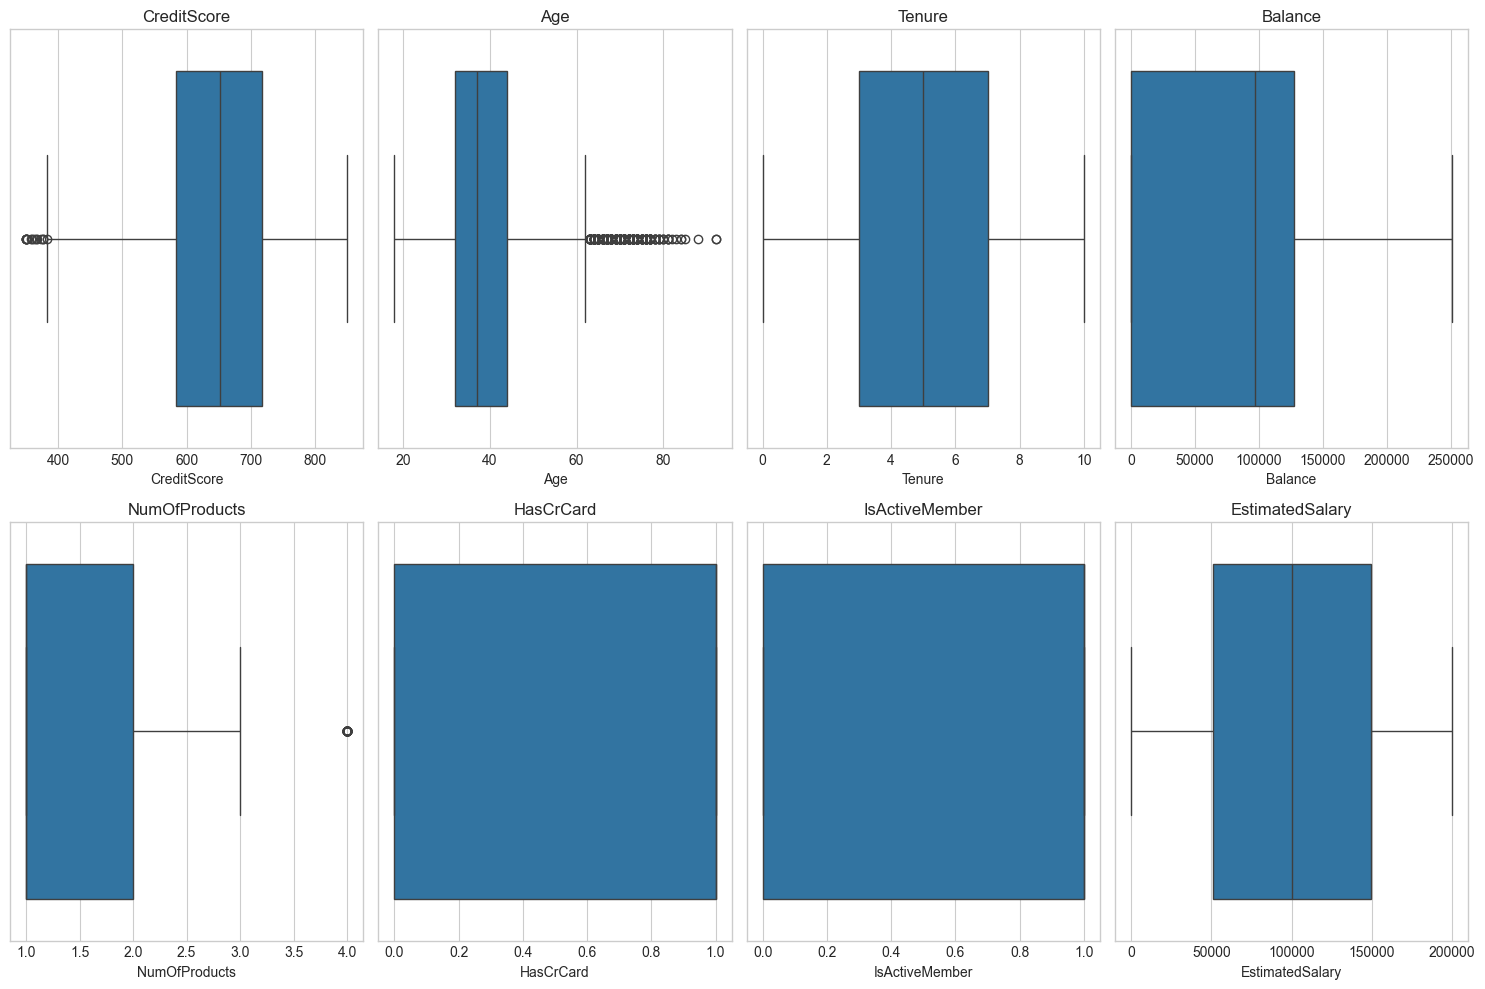

In [10]:
# Check for outliers in numerical columns
numerical_cols = df_cleaned.select_dtypes(include=['int64', 'float64']).columns
numerical_cols = [col for col in numerical_cols if col != 'Exited']

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 4, i+1)
    sns.boxplot(x=df_cleaned[col])
    plt.title(col)
plt.tight_layout()

In [12]:
# Handle outliers if necessary (using IQR method)
def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = ((df[column] < lower_bound) | (df[column] > upper_bound)).sum()
    print(f"{column}: {outliers} outliers detected")
    
    # Cap outliers instead of removing them
    if outliers > 0:
        df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
        df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
            
    return df

# Apply outlier handling to numerical columns
for col in numerical_cols:
    df_cleaned = handle_outliers(df_cleaned, col)

CreditScore: 15 outliers detected
Age: 359 outliers detected
Tenure: 0 outliers detected
Balance: 0 outliers detected
NumOfProducts: 60 outliers detected
HasCrCard: 0 outliers detected
IsActiveMember: 0 outliers detected
EstimatedSalary: 0 outliers detected


## 4. Data Preprocessing

In [ ]:
# One-hot encode categorical variables
df_processed = pd.get_dummies(df_cleaned, columns=['Geography', 'Gender'], drop_first=True) # we drop the first category to avoid dummy variable trap
print(f"Processed dataset shape: {df_processed.shape}")
df_processed.head()

Processed dataset shape: (10000, 12)


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619.0,42.0,2,0.00,1.0,1,1,101348.88,1,False,False,False
1,608.0,41.0,1,83807.86,1.0,0,1,112542.58,0,False,True,False
2,502.0,42.0,8,159660.80,3.0,1,0,113931.57,1,False,False,False
3,699.0,39.0,1,0.00,2.0,0,0,93826.63,0,False,False,False
4,850.0,43.0,2,125510.82,1.0,1,1,79084.10,0,False,True,False


In [14]:
# Convert binary columns to proper format
binary_cols = ['HasCrCard', 'IsActiveMember']
for col in binary_cols:
    df_processed[col] = df_processed[col].astype(int)

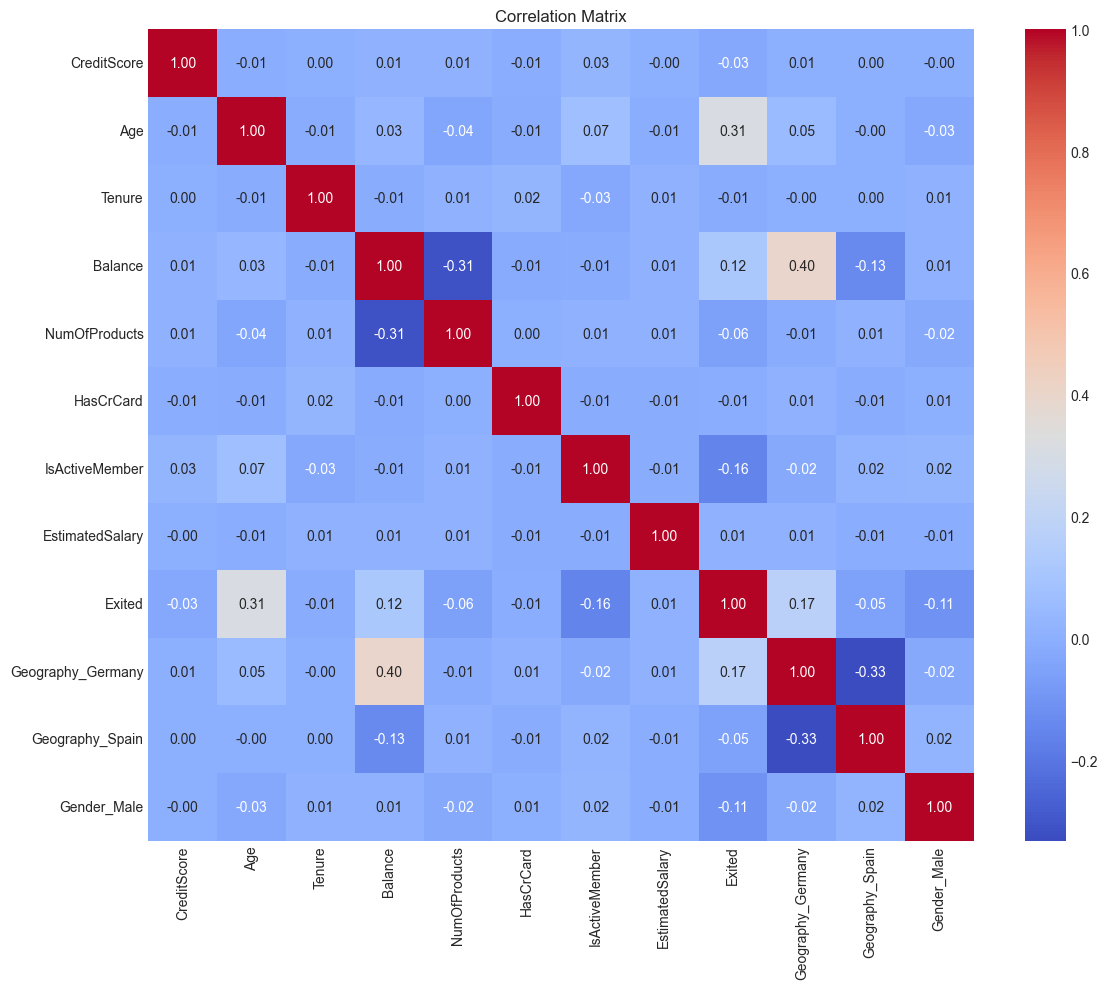

In [15]:
# Check correlation matrix
plt.figure(figsize=(12, 10))
correlation_matrix = df_processed.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.tight_layout()

## 5. Save Processed Data

In [17]:
# Save the cleaned data
save_processed_data(df_cleaned, CLEANED_DATA_PATH)
print(f"Cleaned data saved to {CLEANED_DATA_PATH}")

# Save the processed data
save_processed_data(df_processed, PROCESSED_DATA_PATH)
print(f"Processed data saved to {PROCESSED_DATA_PATH}")

Saving processed data to ../data/cleaned/churn_cleaned.csv
Cleaned data saved to ../data/cleaned/churn_cleaned.csv
Saving processed data to ../data/processed/churn_processed.csv
Processed data saved to ../data/processed/churn_processed.csv


## 6. Data Dictionary

In [18]:
# Create a data dictionary
data_dictionary = {
    'CreditScore': 'Credit score of the customer',
    'Geography': 'Customer\'s location (France, Spain, Germany)',
    'Gender': 'Customer\'s gender (Male, Female)',
    'Age': 'Customer\'s age in years',
    'Tenure': 'Number of years the customer has been a client of the bank',
    'Balance': 'Account balance',
    'NumOfProducts': 'Number of bank products the customer uses',
    'HasCrCard': 'Whether the customer has a credit card (1=Yes, 0=No)',
    'IsActiveMember': 'Whether the customer is an active member (1=Yes, 0=No)',
    'EstimatedSalary': 'Estimated salary of the customer',
    'Exited': 'Whether the customer has churned (1=Yes, 0=No)',
    'Geography_Germany': 'Whether the customer is from Germany (1=Yes, 0=No)',
    'Geography_Spain': 'Whether the customer is from Spain (1=Yes, 0=No)',
    'Gender_Male': 'Whether the customer is male (1=Yes, 0=No)'
}

# Display the data dictionary
pd.DataFrame(list(data_dictionary.items()), columns=['Feature', 'Description'])

,Feature,Description
0,CreditScore,Credit score of the customer
1,Geography,"Customer's location (France, Spain, Germany)"
2,Gender,"Customer's gender (Male, Female)"
3,Age,Customer's age in years
4,Tenure,Number of years the customer has been a client...
5,Balance,Account balance
6,NumOfProducts,Number of bank products the customer uses
7,HasCrCard,"Whether the customer has a credit card (1=Yes,..."
8,IsActiveMember,Whether the customer is an active member (1=Ye...
9,EstimatedSalary,Estimated salary of the customer


In [21]:
# Save the data dictionary
data_dict_df = pd.DataFrame(list(data_dictionary.items()), columns=['Feature', 'Description'])
output_path = '../docs/data_dictionary.csv'
os.makedirs(os.path.dirname(output_path), exist_ok=True)
data_dict_df.to_csv(output_path, index=False)
print("Data dictionary saved to ../docs/data_dictionary.csv")

Data dictionary saved to ../docs/data_dictionary.csv


## 7. Summary

In this notebook, we have:
1. Loaded the bank customer churn dataset
2. Explored the data structure and identified key characteristics
3. Cleaned the data by removing unnecessary columns and handling outliers
4. Preprocessed the data by encoding categorical variables
5. Saved the cleaned and processed datasets
6. Created and saved a data dictionary

The dataset is now ready for exploratory data analysis and feature engineering.